# Robust model fitting

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares
import scipy.ndimage
from skimage import color
import skimage

## Hough Transform

### Exercise 7.1

(480, 640, 3) (480, 640)


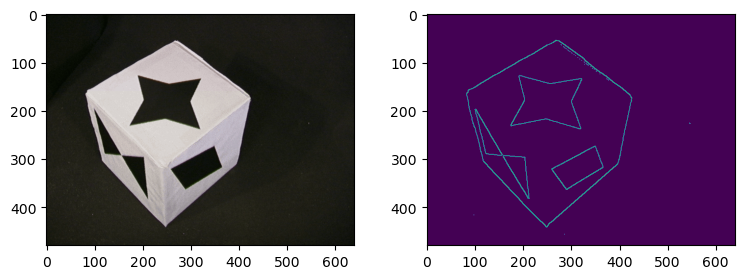

In [89]:
im = cv2.imread('data/Box3.bmp')[:,:,::-1]
edges = cv2.Canny(im,400,400)

print(im.shape, edges.shape)

fig, ax = plt.subplots(1,2, figsize=(9,3))
ax[0].imshow(im)
ax[1].imshow(edges)
plt.show()

### Exercise 7.2

In [90]:
hspace, angles, distances = skimage.transform.hough_line(edges)

### Exercise 7.3

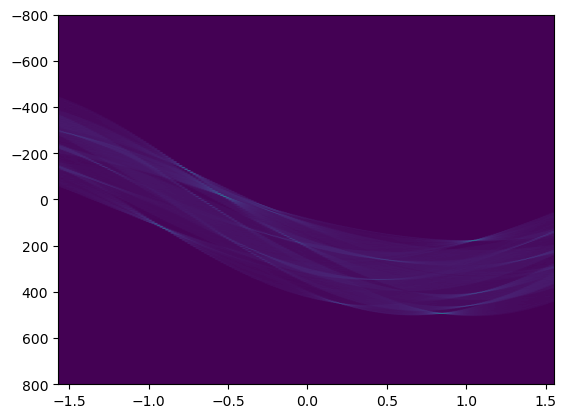

In [91]:
extent = [angles[0], angles[-1], distances[-1], distances[0]]
plt.imshow(hspace, extent=extent, aspect='auto')
plt.show()

### Exercise 7.4

In [105]:
n = 50 # Maximum number of peaks
extH, extAngles, extDists = skimage.transform.hough_line_peaks(hspace, angles, distances, num_peaks=n)

print(extAngles, extDists)

[ 0.85521133  1.04719755 -0.54105207 -0.76794487 -0.9250245   0.20943951
  1.02974426] [ 495.  180.  -17. -129.  121.  452.  461.]


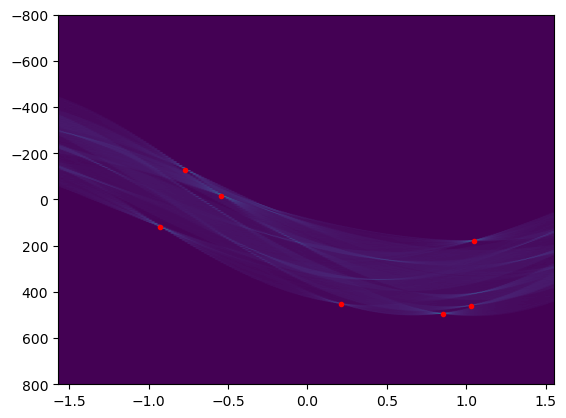

In [106]:
plt.imshow(hspace, extent=extent, aspect='auto')
plt.plot(extAngles,extDists, 'r.')
plt.show()

### Exercise 7.5

In [107]:
def DrawLine(l, shape):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    if (len(P)==0):
        print("Line is completely outside image")
    plt.plot(*np.array(P).T)

In [108]:
l.shape

(3, 7)

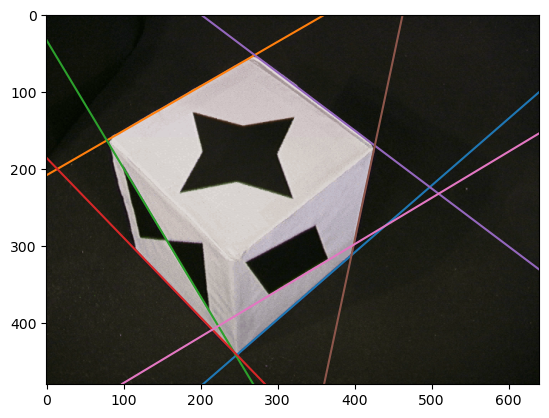

In [109]:
l = np.vstack((np.cos(extAngles), np.sin(extAngles)))
l = np.vstack((l,-extDists))

plt.imshow(im)
for i in range(l.shape[1]):
    DrawLine(l[:,i], im.shape)

## RANSAC

In [2]:
def test_points(n_in, n_out):
    a = (np.random.rand(n_in)-.5)*10
    b = np.vstack((a, a*.5+np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T

In [3]:
def Pi(points):
    if points.ndim == 2:
        n,p = points.shape
        new_points = np.vstack((points, np.ones(p)))
    elif points.ndim == 1:
        n = len(points)
        new_points = np.append(points, [1])
    return new_points

def PiInv(points):
    n,p = points.shape
    new_points = points[:-1]/points[-1]
    return new_points

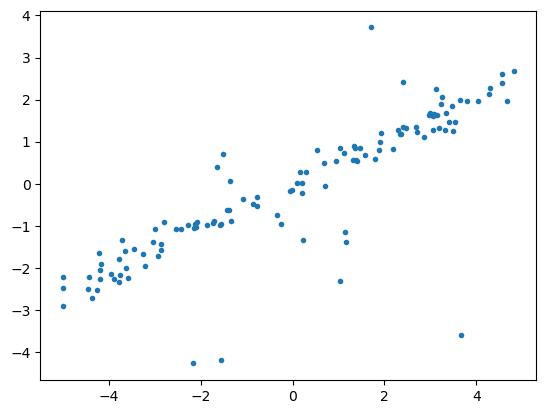

In [4]:
nin = 100
nout = 20 
Q = test_points(nin,nout)

plt.plot(Q[0,:], Q[1,:], '.')
plt.show()

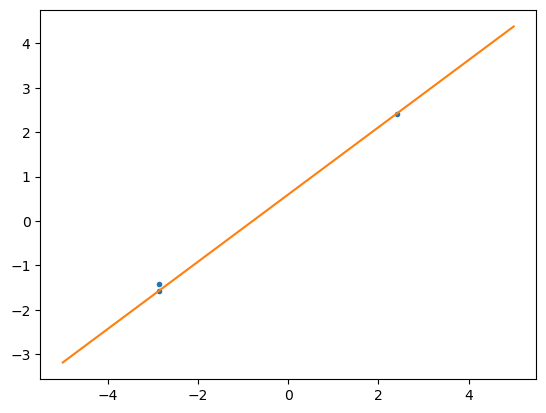

In [9]:
# Testing 
q1, q2 = draw(Q)
l = line(Pi(q1), Pi(q2))
q3 = Q[:,1]
x0 = -5
x1 = 5
y0 = - l[0]/l[1]*x0 - l[2]/l[1]
y1 = - l[0]/l[1]*x1 - l[2]/l[1]

plt.plot([q1[0], q2[0], q3[0]], [q1[1], q2[1], q3[1]], '.')
plt.plot([x0, x1], [y0, y1])
plt.show()

In [12]:
l = line(Pi(q1), Pi(q2))

In [13]:
q1.shape

(2,)

### Exercise 7.6

In [8]:
def line(q1, q2):
    l = np.cross(q1, q2)
    l = l/np.sqrt(l[0]**2+l[1]**2)
    return l

### Exercise 7.7

In [222]:
def getinliers(Q, l, tau):
    Qh = Pi(Q)
    inliers = []
    outliers = []
    for i in range(Qh.shape[1]):
        d = abs(np.dot(l, Qh[:,i]))
        if d <= tau:
            inliers.append(Q[:,i])
        else:
            outliers.append(Q[:,i])
    inliers = np.array(inliers)
    outliers = np.array(outliers)
    return inliers, outliers

### Exercise 7.8

In [223]:
def consensus(Q, l, tau):
    inliers, outliers = getinliers(Q, l, tau)
    return len(inliers)

### Exercise 7.9

In [6]:
def draw(Q):
    Q = np.random.permutation(Q.T).T
    return Q[:,0], Q[:,1]

### Exercise 7.10

In [230]:
def RANSAC(Q, nit, tau):
    nmax_inliers = 0
    lfit = 0
    for i in range(nit):
        q1, q2 = draw(Q)
        print(q1,q2)
        l = line(Pi(q1), Pi(q2))
        n_inliers = consensus(Q, l, tau)
        if n_inliers > nmax_inliers:
            nmax_inliers = n_inliers
            lfit = l
    return lfit

### Exercise 7.11

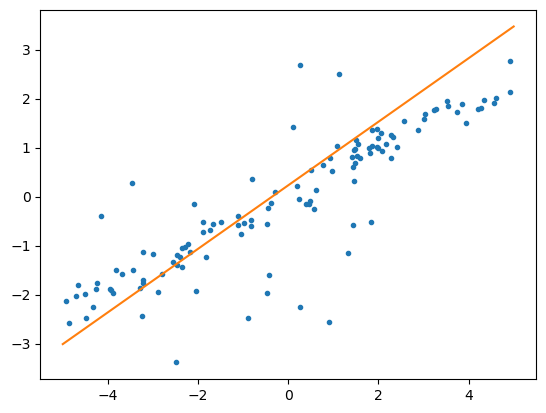

In [259]:
l = RANSAC(Q, 100, 2)

x0 = -5
x1 = 5
y0 = - l[0]/l[1]*x0 - l[2]/l[1]
y1 = - l[0]/l[1]*x1 - l[2]/l[1]
n
plt.plot(Q[0,:], Q[1,:], '.')
plt.plot([x0, x1], [y0, y1])
plt.show()

### Exercise 7.12

In [261]:
def pca_line(x): #assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l@x.mean(1)))
    return l

In [270]:
def RANSAC(Q, nit, tau):
    nmax_inliers = 0
    lfit = 0
    for i in range(nit):
        q1, q2 = draw(Q)
        l = line(Pi(q1), Pi(q2))
        n_inliers = consensus(Q, l, tau)
        if n_inliers > nmax_inliers:
            nmax_inliers = n_inliers
            lfit = l
    inliers, outliers = getinliers(Q, lfit, tau)
    lfit = pca_line(inliers.T)
    return lfit

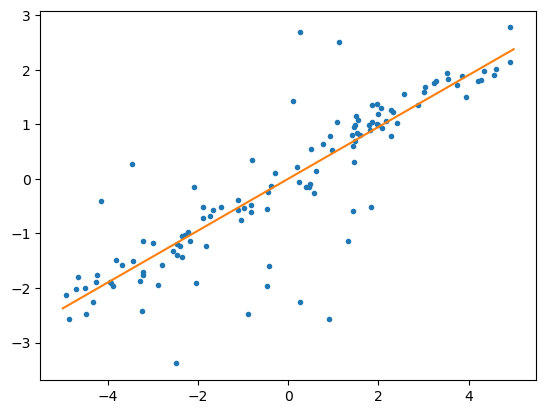

In [271]:
l = RANSAC(Q, 100, 2)

x0 = -5
x1 = 5
y0 = - l[0]/l[1]*x0 - l[2]/l[1]
y1 = - l[0]/l[1]*x1 - l[2]/l[1]
n
plt.plot(Q[0,:], Q[1,:], '.')
plt.plot([x0, x1], [y0, y1])
plt.show()

### Exercise 7.13

In [280]:
def RANSAC(Q, tau):
    p = 0.99
    m = Q.shape[1]
    nmax_inliers = 0
    lfit = 0
    N = 0
    Nhat = 10
    while N <= Nhat:
        q1, q2 = draw(Q)
        l = line(Pi(q1), Pi(q2))
        n_inliers = consensus(Q, l, tau)
        if n_inliers > nmax_inliers:
            nmax_inliers = n_inliers
            lfit = l
        epshat = 1 - nmax_inliers/m
        Nhat = np.log(1-p)/np.log(1-(1-epshat)**2)
        N += 1
    inliers, outliers = getinliers(Q, lfit, tau)
    lfit = pca_line(inliers.T)
    return lfit, N

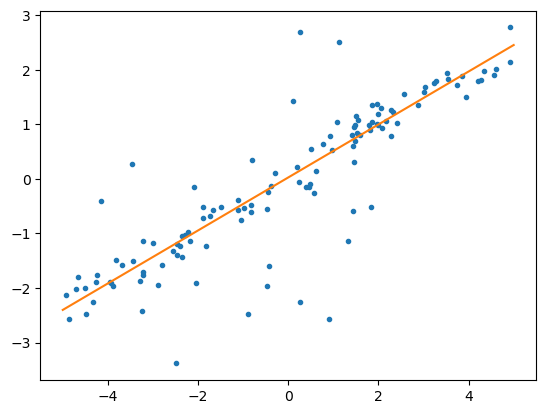

4


In [284]:
l, nit = RANSAC(Q, 1)

x0 = -5
x1 = 5
y0 = - l[0]/l[1]*x0 - l[2]/l[1]
y1 = - l[0]/l[1]*x1 - l[2]/l[1]
n
plt.plot(Q[0,:], Q[1,:], '.')
plt.plot([x0, x1], [y0, y1])
plt.show()

print(nit)